# GE Stock Prediction
Here we are going to predict GE stock prices. Example from https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [1]:
# Import Required Libraries
# Graph Functions
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
import pandas as pd
import os


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/ai/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Import and Inspect Data

In [54]:
display(os.getcwd())
df_ge = pd.read_csv('../../../data/price_ge_stock.csv', engine='python', parse_dates=['Date'])
df_ge = df_ge.drop(['OpenInt'], axis=1)
df_ge = df_ge.set_index('Date')
df_ge.tail()

'/Users/kamilbukum/Development/ml/DataModelingStepsML/notebooks/deep_learning/price_precitions'

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-06,20.52,20.530,20.08,20.13,60641787
2017-11-07,20.17,20.250,20.12,20.21,41622851
2017-11-08,20.21,20.320,20.07,20.12,39672190
2017-11-09,20.04,20.071,19.85,19.99,50831779
2017-11-10,19.98,20.680,19.90,20.49,100698474


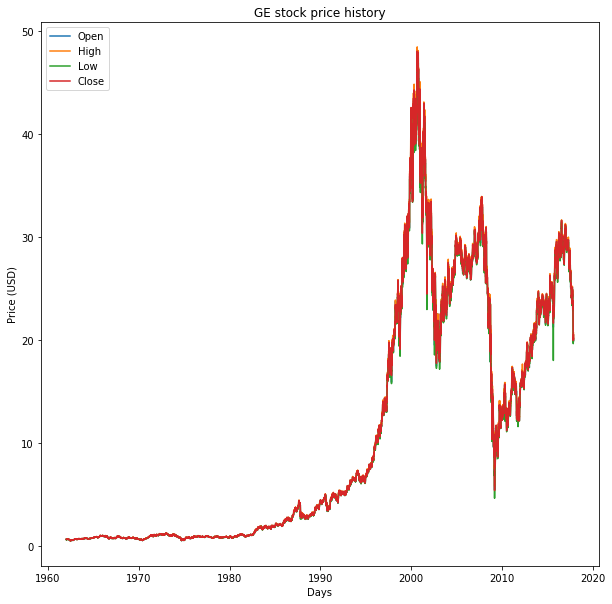

In [55]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [56]:
df_ge['diff']=df_ge['High']-df_ge['Low']
df_ge

,Open,High,Low,Close,Volume,diff
Date,,,,,,
1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0.0161
1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0.0079
1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0.0164
1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0.0324
1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0.0241
...,...,...,...,...,...,...
2017-11-06,20.5200,20.5300,20.0800,20.1300,60641787,0.4500
2017-11-07,20.1700,20.2500,20.1200,20.2100,41622851,0.1300
2017-11-08,20.2100,20.3200,20.0700,20.1200,39672190,0.2500


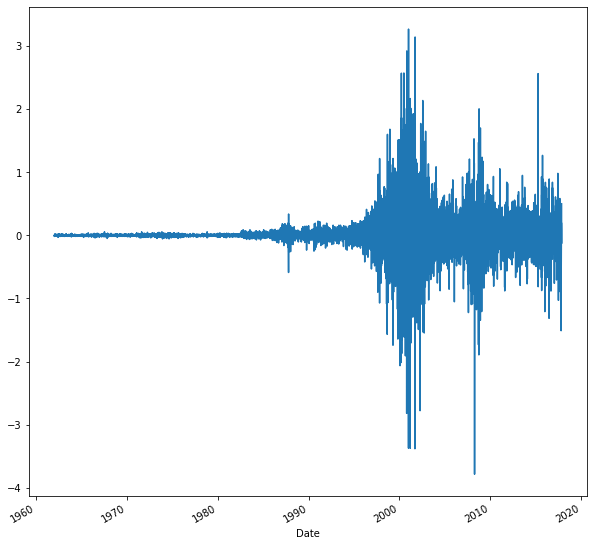

In [101]:
df_ge['ddiff'] = df_ge['Close'] - df_ge['Close'].shift(1)
df_ge
df_ge['ddiff'].plot()

In [102]:
df_ge.shape

(14058, 7)

In [103]:
df_ge.dropna().shape
df_ge = df_ge.dropna()

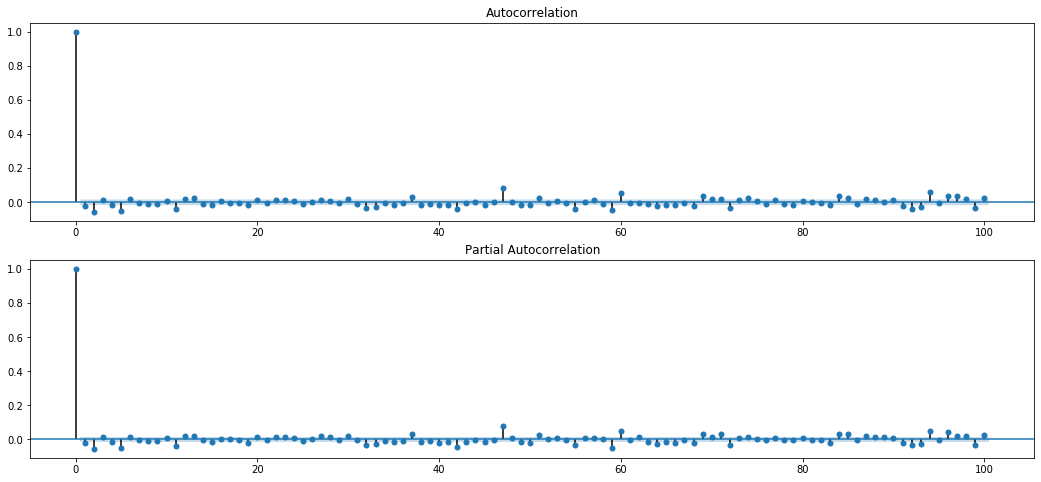

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))
plt.subplot(211)
plot_acf(df_ge['ddiff'], lags=100, ax=plt.gca())
plt.subplot(212)
plot_pacf(df_ge['ddiff'], lags=100, ax=plt.gca())
plt.show()

## Preprocess the Data
We need to normalize the data in order to improve convergence time.

In [106]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["diff","Close","Volume", "ddiff"]
#train_cols = ["Open","High","Low","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(df_train.loc[:, "Close"].values, (-1, 1)))

Train and Test size 11245 2812


array([[0.00338425],
       [0.00321827],
       [0.00287161],
       ...,
       [0.56564471],
       [0.57270398],
       [0.57677987]])

## Reshape the Data for Training
Our current dataset is not in a form suitable for training.

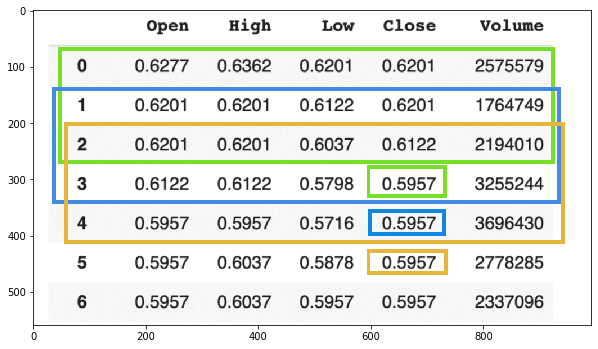

In [107]:
import matplotlib.image as mpimg
img = mpimg.imread('stock_training1.png')
plt.imshow(img)

In [108]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [109]:
TIME_STEPS = 5
BATCH_SIZE = 32
x_t, y_t = build_timeseries(x_train, 1, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 1, TIME_STEPS)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11240, 5, 4) (11240,)
length of time-series i/o (2807, 5, 4) (2807,)


## Model Creation
Time to create our Keras Model

In [171]:
# Import functions from Keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import keras
lstm_model = Sequential()
lstm_model.add(LSTM(50, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='tanh'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1,activation='linear'))
opt = keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss='mse', optimizer=opt,metrics=['mse'])
lstm_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (32, 50)                  11000     
_________________________________________________________________
dropout_28 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_50 (Dense)             (32, 20)                  1020      
_________________________________________________________________
dropout_29 (Dropout)         (32, 20)                  0         
_________________________________________________________________
dense_51 (Dense)             (32, 1)                   21        
Total params: 12,041
Trainable params: 12,041
Non-trainable params: 0
_________________________________________________________________


# Plot Model
The following code is to plot your created model. If you do not have certain outside libraries installed, the code may not run. This is Okay. You do not need this code to do the assignment.

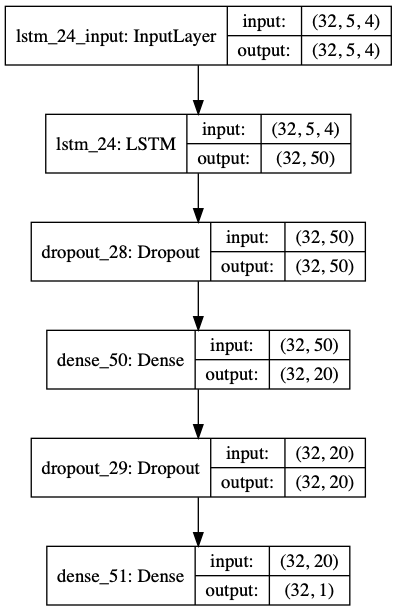

In [172]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot
plot_model(lstm_model, show_shapes = True)

# Train and Plot Model Performance

Train on 11232 samples, validate on 1376 samples
Epoch 1/50
11232/11232 [==============================] - 3s 274us/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/50
11232/11232 [==============================] - 2s 200us/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/50
11232/11232 [==============================] - 2s 200us/step - loss: 0.0047 - mse: 0.0047 - val_loss: 6.2727e-04 - val_mse: 6.2727e-04
Epoch 4/50
11232/11232 [==============================] - 3s 250us/step - loss: 0.0044 - mse: 0.0044 - val_loss: 3.4581e-04 - val_mse: 3.4581e-04
Epoch 5/50
11232/11232 [==============================] - 3s 284us/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/50
11232/11232 [==============================] - 2s 221us/step - loss: 0.0043 - mse: 0.0043 - val_loss: 2.8932e-04 - val_mse: 2.8932e-04
Epoch 7/50
11232/11232 [==============================] - 3s 225us/step - loss: 0.0043 - mse: 0.004

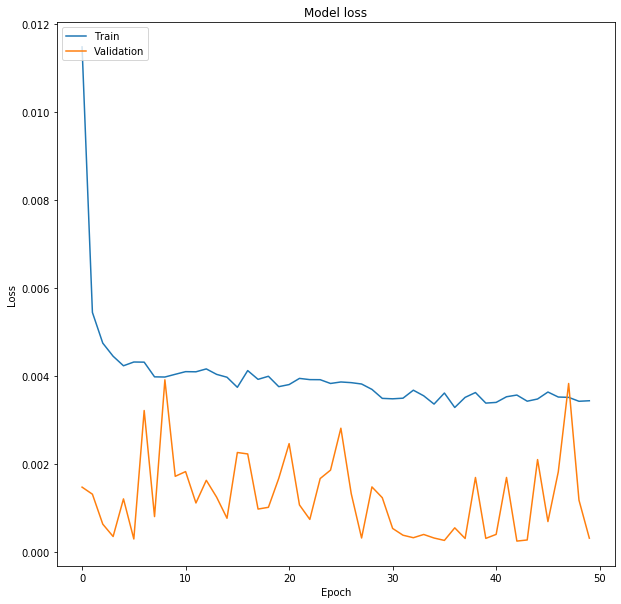

In [173]:
history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=50, verbose=1,
          validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                           trim_dataset(y_val, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Generate Performance Metrics

In [174]:
score = lstm_model.evaluate(x_t, y_t, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1] )

11232/11232 [==============================] - 1s 57us/step
Test score: 0.0002260852323499882
Test accuracy: 0.00022608523431699723


# Plot Validation Data against Actual

In [175]:
predicted = lstm_model.predict(trim_dataset(x_val, BATCH_SIZE))
display(predicted)

array([[0.5847129 ],
       [0.5847497 ],
       [0.58090025],
       ...,
       [0.3278318 ],
       [0.32624787],
       [0.3156551 ]], dtype=float32)

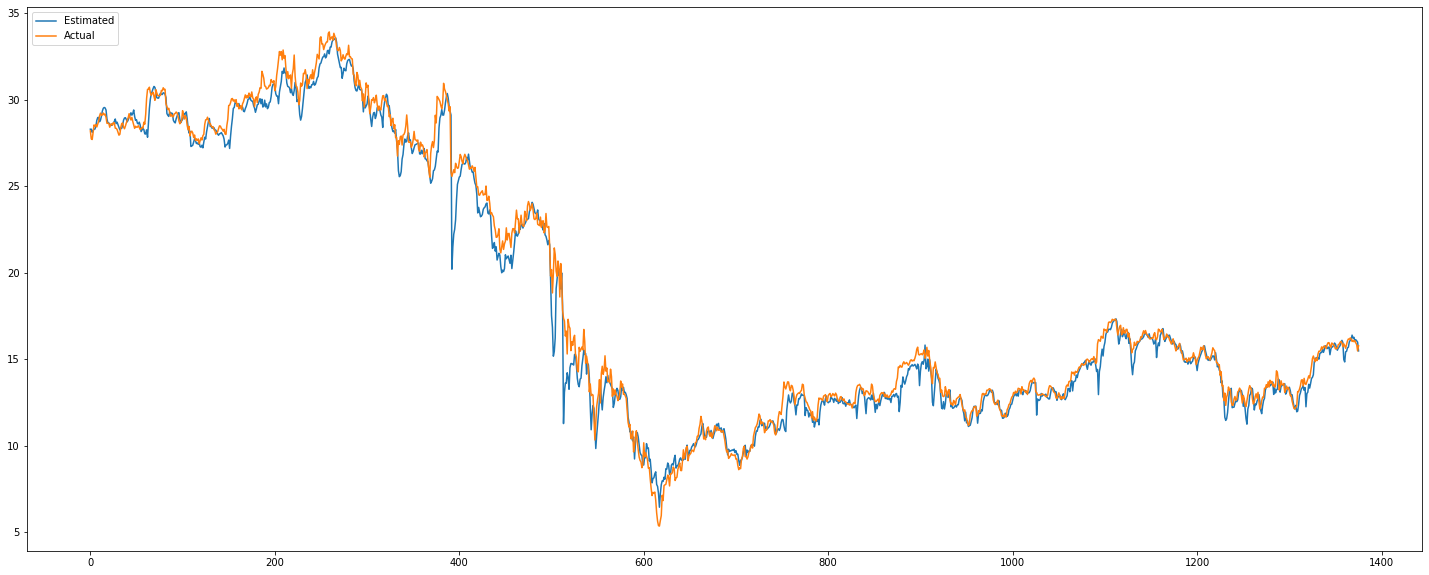

In [178]:
plt.figure(figsize=(25, 10))
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

# Create Your Own Stock Prediction Algorithm
Follow similar steps to the above code, but for your own algorithm. Choose any stock and collect the data yourself. Please turn in a .txt or .csv file that contains the data.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import metrics
np.set_printoptions(precision=6, suppress=True)

In [8]:
df_tesla = pd.read_csv('../../../data/price_tesla.csv', engine='python')
df_tesla.set_index("Date", inplace=True)
# df_tesla.drop(["OpenInt"], axis=1, inplace=True)
df_tesla.drop(["Adj Close"], axis=1, inplace=True)
df_tesla.dropna()
df_tesla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-03-23,34.259998,34.630001,33.150002,34.080002,1170600
2012-03-26,35.590000,38.090000,35.040001,37.400002,3140500
2012-03-27,37.160000,39.950001,37.029999,37.939999,2539200
2012-03-28,37.779999,38.439999,37.110001,37.849998,955000
2012-03-29,38.189999,38.189999,37.029999,37.330002,796400


In [9]:
print("Nan values")
df_tesla.isna().sum()
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

Nan values


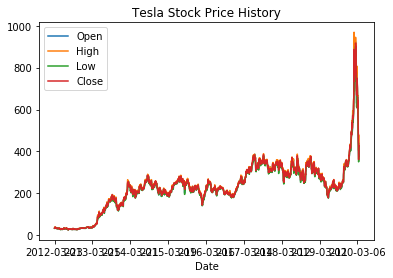

In [10]:
df_tesla.plot(y = ['Open', 'High', 'Low', 'Close'], title='Tesla Stock Price History')

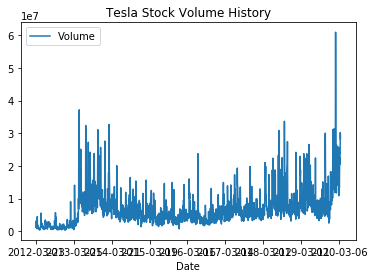

In [11]:
df_tesla.plot(y = ['Volume'], title='Tesla Stock Volume History')

### Preprocessing

#### Extract Features

In [12]:
#### Extract Features
def create_features(data):
    features = []
    # Open	High	Low	Close	Volume
    data_t = data.values.T
    daily_mean = np.mean(data_t[3]-data_t[0])
    high_mean = np.mean(data_t[1])
    low_mean = np.mean(data_t[2])
    volume_mean = np.mean(data_t[4])
    features.append(daily_mean)
    features.append(high_mean)
    features.append(low_mean)  
    features.append(volume_mean)
    return features     

def extract_feautures(df, diff_size):
    diff_sample_size = df.shape[0]-diff_size-10
    items = []
    for i in tqdm(range(diff_sample_size)):
        start = i
        end = i + diff_size
        data = df[start:end]
        features = create_features(data)
        output = df["Close"].values[end + 10]
        features.append(output)
        items.append(features)
    return np.array(items)

In [13]:
DIFF_SIZE = 10
tesla_data = extract_feautures(df_tesla, DIFF_SIZE)

100%|██████████| 1991/1991 [00:00<00:00, 4009.98it/s]


In [14]:
tesla_output = tesla_data[:, tesla_data.shape[1]-1]
# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(tesla_output, (-1, 1)))
print("scaled output")

scaled output


In [15]:
print(df_tesla.shape, "->", tesla_data.shape)

(2011, 5) -> (1991, 5)


#### Split Data as Train, Validation and Test

In [16]:
tesla_train, tesla_test_temp = train_test_split(tesla_data, test_size=0.2, shuffle=False)
tesla_validation, tesla_test = train_test_split(tesla_test_temp, test_size=0.5, shuffle=False)

In [17]:
print(tesla_data.shape, "->", tesla_train.shape, " - ", tesla_validation.shape, " - ", tesla_test.shape)

(1991, 5) -> (1592, 5)  -  (199, 5)  -  (200, 5)


In [18]:
#### Fit the data MinMax

In [19]:
# scale the feature MinMax
min_max_scaler = MinMaxScaler()

In [20]:
# scale the training data
tesla_train_x_f = min_max_scaler.fit_transform(tesla_train)

In [21]:
# scale the validation data
tesla_validation_x_f = min_max_scaler.transform(tesla_validation)

In [22]:
# scale the test data
tesla_test_x_f = min_max_scaler.transform(tesla_test)

#### Transform training data by time step

In [23]:
def create_dimension_time_step(temp_x, time_step):
    sample_size  = temp_x.shape[0] - time_step
    feature_size = temp_x.shape[1]
    x = np.zeros((sample_size, time_step, feature_size))
    y = np.zeros(sample_size)
    for i in range(sample_size-1):
        end = i + time_step
        x[i] = temp_x[i: end, :]
        y[i] = temp_x[end + 1, int(temp_x.shape[1]-1)]
    return x, y
TIME_STEP = 4
print(tesla_train_x_f.shape)

(1592, 5)


In [24]:
# Transform training data by time step
tesla_train_x_t, tesla_train_y_t = create_dimension_time_step(tesla_train_x_f, TIME_STEP)
print(tesla_train_x_f.shape, "->", tesla_train_x_t.shape)

(1592, 5) -> (1588, 4, 5)


In [25]:
# Transform validation data by time step
tesla_validation_x_t, tesla_validation_y_t = create_dimension_time_step(tesla_validation_x_f, TIME_STEP)
print(tesla_validation_x_f.shape, "->", tesla_validation_x_t.shape)

(199, 5) -> (195, 4, 5)


In [26]:
# Transform test data by time step
tesla_test_x_t, tesla_test_y_t = create_dimension_time_step(tesla_test_x_f, TIME_STEP)

In [27]:
def module_data_by_batch_size(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
BATCH_SIZE=32

In [28]:
#### Truncute training data batch Size
tesla_train_x_b = module_data_by_batch_size(tesla_train_x_t, BATCH_SIZE)
print(tesla_train_x_t.shape, "->", tesla_train_x_b.shape)
tesla_train_y_b = module_data_by_batch_size(tesla_train_y_t, BATCH_SIZE)
print(tesla_train_y_t.shape, "->", tesla_train_y_b.shape)

(1588, 4, 5) -> (1568, 4, 5)
(1588,) -> (1568,)


In [29]:
#### Truncute validation data batch Size
tesla_validation_x_b = module_data_by_batch_size(tesla_validation_x_t, BATCH_SIZE)
print(tesla_validation_x_t.shape, "->", tesla_validation_x_b.shape)
tesla_validation_y_b = module_data_by_batch_size(tesla_validation_y_t, BATCH_SIZE)
print(tesla_validation_y_t.shape, "->", tesla_validation_y_b.shape)

(195, 4, 5) -> (192, 4, 5)
(195,) -> (192,)


In [30]:
#### Truncute test data batch Size
tesla_test_x_b = module_data_by_batch_size(tesla_test_x_t, BATCH_SIZE)
print(tesla_test_x_t.shape, "->", tesla_test_x_b.shape)
tesla_test_y_b = module_data_by_batch_size(tesla_test_y_t, BATCH_SIZE)
print(tesla_test_y_t.shape, "->", tesla_test_y_b.shape)

(196, 4, 5) -> (192, 4, 5)
(196,) -> (192,)


In [31]:
### Model Creation

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (tesla_train_x_b.shape[1],  tesla_train_x_b.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 50)             11200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 50)             20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [33]:
print(tesla_train_x_b.shape, tesla_train_y_b.shape)

(1568, 4, 5) (1568,)


In [34]:
model_history = model.fit(
    tesla_train_x_b,tesla_train_y_b, 
    epochs=100, 
    batch_size=BATCH_SIZE,
    validation_data=(tesla_validation_x_b, tesla_validation_y_b)
)

Train on 1568 samples, validate on 192 samples
Epoch 1/100
1568/1568 [==============================] - 3s 2ms/step - loss: 0.0968 - val_loss: 0.0099
Epoch 2/100
1568/1568 [==============================] - 1s 339us/step - loss: 0.0100 - val_loss: 0.0051
Epoch 3/100
1568/1568 [==============================] - 1s 359us/step - loss: 0.0070 - val_loss: 0.0052
Epoch 4/100
1568/1568 [==============================] - 1s 351us/step - loss: 0.0064 - val_loss: 0.0050
Epoch 5/100
1568/1568 [==============================] - 1s 324us/step - loss: 0.0059 - val_loss: 0.0045
Epoch 6/100
1568/1568 [==============================] - 0s 314us/step - loss: 0.0051 - val_loss: 0.0079
Epoch 7/100
1568/1568 [==============================] - 0s 313us/step - loss: 0.0052 - val_loss: 0.0038
Epoch 8/100
1568/1568 [==============================] - 0s 314us/step - loss: 0.0047 - val_loss: 0.0038
Epoch 9/100
1568/1568 [==============================] - 1s 331us/step - loss: 0.0040 - val_loss: 0.0056
Epoch 10/1

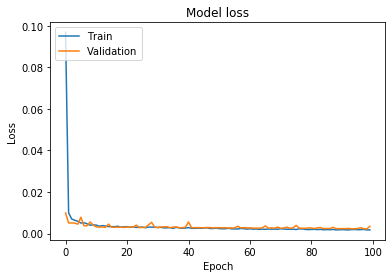

In [35]:
# Plot training & validation loss values
plt.figure()
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

### Show Accuracy

In [36]:
print(tesla_test_x_b.shape, tesla_test_y_b.shape)

(192, 4, 5) (192,)


In [37]:
score = model.evaluate(tesla_train_x_b, tesla_train_y_b, verbose=1)
print('Test score:', score)

1568/1568 [==============================] - 0s 92us/step
Test score: 0.001199812557796558


In [38]:
model_predicted = model.predict(tesla_validation_x_b)

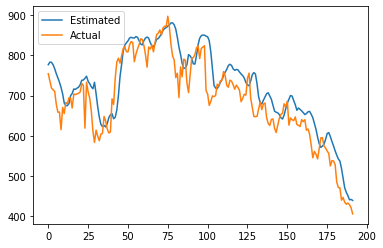

In [39]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(model_predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(tesla_validation_y_b, (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

In [40]:
model_predicted = model.predict(tesla_test_x_b)

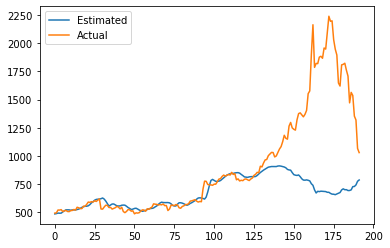

In [41]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(model_predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(tesla_test_y_b, (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')